In [1]:
import os
import numpy as np
import pandas as pd
import janitor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import math
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
import plotly.graph_objects as go
pyo.init_notebook_mode()

import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

import country_converter as coco
cc = coco.CountryConverter()


%matplotlib inline

In [2]:
tls_801 = pd.read_csv(r"./EU_CH_scope/table_tls801.csv", low_memory=False)
# tls_801.head()
scope_df = tls_801[((tls_801.eu_member=="Y")|
                      (tls_801.ctry_code == 'NO')|
                      (tls_801.ctry_code == 'CH')|
                      (tls_801.ctry_code == 'GB'))]
scope_countries = scope_df["ctry_code"].unique()

In [44]:
print(tls_801[tls_801["ctry_code"]=="MA"])

    ctry_code iso_alpha3 st3_name organisation_flag continent eu_member   
137        MA        MAR  Morocco                      Africa            \

    epo_member oecd_member discontinued  
137                                      


In [3]:
outdir="raw_files_csv"

In [4]:
appln = pd.read_csv(f"{outdir}/01_patent_subset.csv", low_memory=False)
appln.sample(10)

appln_id appln_auth      appln_nr appln_kind appln_filing_date   
8641708   531710630         CN  201811380088          A        2018-11-20  \
5246513   489770910         CN  201711004155          A        2017-10-24   
6383260   503205376         CN  201810447617          A        2018-05-11   
1437288   417129813         GR   20120100519          A        2012-10-12   
4304665   479561975         CN  201510807721          A        2015-11-19   
8099995   524172492         CN  201911055629          A        2019-10-31   
2496404   443580404         CN  201510312381          A        2015-06-08   
2862771   448112136         CN  201510736913          A        2015-11-03   
8746800   533540106         CN  202010109483          A        2020-02-22   
12407625  580940603         CN  202210840515          A        2022-07-18   

          appln_filing_year appln_nr_original ipr_type receiving_office   
8641708                2018      201811380088       PI              NaN  \
5246513                2017      201711004155       PI              NaN   
6383260                2018      201810447617       PI              NaN   
1437288                2012       20120100519       PI              NaN   
4304665                2015      201510807721       PI              NaN   
8099995                2019      201911055629       PI              NaN   
2496404                2015     2015103123811       PI              NaN   
2862771                2015     2015107369134       PI              NaN   
8746800                2020      202010109483       PI              NaN   
12407625               2022      202210840515       PI              NaN   

          internat_appln_id  ... earliest_pat_publn_id granted   
8641708                   0  ...             531710631       N  \
5246513                   0  ...             489770911       N   
6383260                   0  ...             503205377       N   
1437288                   0  ...             417129814       Y   
4304665                   0  ...             479561976       N   
8099995                   0  ...             524172493       N   
2496404                   0  ...             443580405       N   
2862771                   0  ...             448112137       N   
8746800                   0  ...             533540107       Y   
12407625                  0  ...             580940604       N   

         docdb_family_id inpadoc_family_id  docdb_family_size   
8641708         70744210         531710630                  1  \
5246513         61141626         489770910                  1   
6383260         64213024         503205376                  1   
1437288         50483672         417129813                  1   
4304665         58885008         479561975                  1   
8099995         68978631         524172492                  1   
2496404         53812114         443580404                  1   
2862771         54991770         448112136                  1   
8746800         71149074         533540106                  1   
12407625        83518531         580940603                  1   

          nb_citing_docdb_fam nb_applicants  nb_inventors  is_prior is_pct  
8641708                     0             1             1         1      0  
5246513                     0             1             5         1      0  
6383260                     0             1             3         1      0  
1437288                     0             1             1         1      0  
4304665                     0             1             1         1      0  
8099995                     0             1             3         1      0  
2496404                     3             2             3         1      0  
2862771                     2             1             5         1      0  
8746800                     0             1             5         1      0  
12407625                    0             1             6         1      0  

[10 rows x 28 columns]

In [5]:
appln_pers = pd.read_csv(f"{outdir}/02_persons_2011_2022.csv",low_memory=False)
len(appln_pers["appln_id"]), len(appln["appln_id"])

(54368949, 13184309)

In [6]:
appln_pers["appln_id"].isin(appln["appln_id"]).sum(), appln["appln_id"].isin(appln_pers["appln_id"]).sum()

(54368949, 12646904)

In [7]:
appln_ch_ids = appln_pers[appln_pers["person_ctry_code"] == "CN"]["appln_id"].unique()
appln_eu_ids = appln_pers[appln_pers["person_ctry_code"].isin(scope_countries)]["appln_id"].unique()

appln_scope_ids = np.intersect1d(appln_ch_ids, appln_eu_ids, assume_unique=False)
appln_scope = appln_pers[((appln_pers["appln_id"].isin(appln_scope_ids)) &
                          (appln_pers["person_ctry_code"].isin(list(scope_countries) + ["CN"])))]

appln_scope["appln_id"].nunique()

12415

In [8]:
appln_pers_haninfo = pd.read_csv(f"first_round/tls_206_scope_v2.csv",
                                 usecols=["person_id", "han_id", "han_name", "psn_sector"])

appln_pers_haninfo["han_id"].nunique(), appln_scope["han_id"].nunique()

(6584667, 18789)

In [ ]:
pers_sector_primary = appln_pers_haninfo.groupby("han_id", as_index=False)["psn_sector"].agg(
    lambda x: "UNKNOWN" if len(pd.Series.mode(x))==0 else pd.Series.mode(x)[0]).rename(columns={"psn_sector":"psn_sector_primary"})

In [80]:
appln_pers_f.columns

Index(['appln_id', 'appln_auth', 'person_id', 'invt_seq_nr', 'applt_seq_nr',
       'person_name', 'person_ctry_code', 'han_id', 'han_name', 'psn_sector_x',
       'psn_sector_y', 'person_ctry_code_fullname', 'appln_auth_fullname',
       'person_ctry_ISO3', 'person_ctry_type', 'auth_ISO3', 'auth_ctry_type',
       'psn_sector_primary_x', 'psn_sector_primary_y'],
      dtype='object')

In [81]:
appln_pers_f = appln_scope.merge(pers_sector_primary, on='han_id', how="left").rename(columns={"psn_sector_primary_y":"psn_sector_primary"})
appln_pers_f["psn_sector_primary"] = appln_pers_f["psn_sector_primary"].fillna("UNKNOWN")
print(appln_pers_f["appln_id"].nunique())

12415


In [84]:
appln_pers_f["han_name"] = appln_pers_f["han_name"].str.replace("Zhejiang Geely Holding Group Co., Ltd.",
                                                                            "ZHEJIANG GEELY HOLDINGGROUP CO LTD")

In [29]:
g = appln_pers.groupby('appln_id')["person_ctry_code"]
missing_ctry_data = g.count().rsub(g.size(), axis=0).ge(1).astype(int).reset_index()

In [186]:
print(appln_pers_f.sample())

        appln_id appln_auth  person_id  invt_seq_nr  applt_seq_nr   
21408  556911606         MA   42012433            2             0  \

            person_name person_ctry_code     han_id          han_name   
21408  TURTINEN, SAMULI               FI  142012433  TURTINEN, SAMULI  \

      psn_sector_x psn_sector_y person_ctry_code_fullname appln_auth_fullname   
21408   INDIVIDUAL   INDIVIDUAL                   Finland             Morocco  \

      person_ctry_ISO3 person_ctry_type auth_ISO3 auth_ctry_type   
21408              FIN               EU       MAR             EU  \

      psn_sector_primary_x psn_sector_primary  
21408           INDIVIDUAL         INDIVIDUAL  


In [190]:
appl_eu_applt = appln_pers_f[((appln_pers_f["applt_seq_nr"]>0)&
                              (appln_pers_f["person_ctry_type"]!="China"))]["appln_id"].unique()

appl_ch_applt = appln_pers_f[((appln_pers_f["applt_seq_nr"]>0)&
                              (appln_pers_f["person_ctry_type"]=="China"))]["appln_id"].unique()

len(appl_eu_applt),len(appl_ch_applt)

(10810, 10084)

In [201]:
appl_eu_invt = appln_pers_f[((appln_pers_f["invt_seq_nr"]>0)&
                              (appln_pers_f["person_ctry_type"]!="China"))]["appln_id"].unique()

appl_ch_invt = appln_pers_f[((appln_pers_f["invt_seq_nr"]>0)&
                              (appln_pers_f["person_ctry_type"]=="China"))]["appln_id"].unique()

len(appl_eu_invt),len(appl_ch_invt)

(7638, 8788)

In [194]:
appln_pers_f[((appln_pers_f["applt_seq_nr"]>0))]["appln_id"].nunique()

12197

In [41]:
# missing_ctry_data[missing_ctry_data["person_ctry_code"]>0]

In [31]:
appln_ana = appln.merge(missing_ctry_data,on="appln_id")

In [32]:
appln_ana["appln_id"].nunique(),appln["appln_id"].nunique()

(12646904, 13184309)

<Axes: xlabel='appln_auth'>

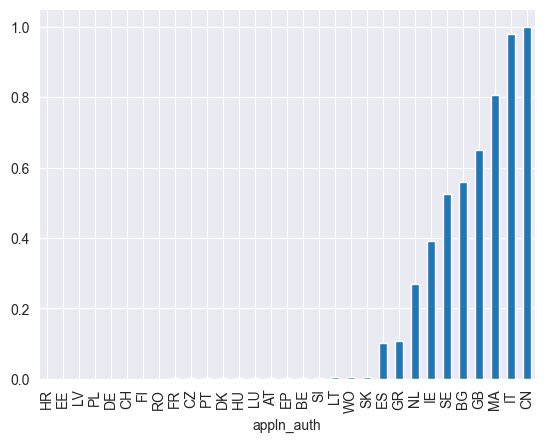

In [45]:
ctry_ana = appln_ana.groupby("appln_auth")["person_ctry_code"]
(ctry_ana.sum()/ctry_ana.size()).sort_values().plot(kind="bar")

<Axes: xlabel='appln_filing_year'>

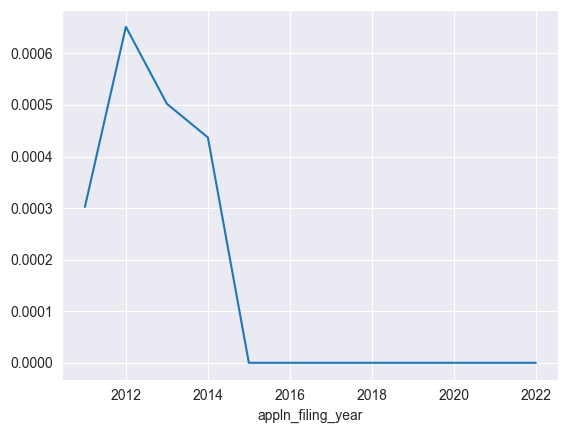

In [51]:
ch_ana = appln_ana.query("appln_auth=='CN'").groupby("appln_filing_year")["person_ctry_code"]
((1-(ch_ana.sum()/ch_ana.size()))*100).plot(kind="line")

In [11]:
# That one Chinese auth co-patent

In [16]:
appln_scope.query("appln_auth=='CN'")

appln_id appln_auth  person_id  invt_seq_nr  applt_seq_nr   
124  419052362         CN    5361204            0             1  \
137  419052362         CN   51988464            1             0   

                           person_name person_ctry_code     han_id   
124  Schneider Electric Industries SAS               FR     808003  \
137                       JUZHONG SONG               CN  151988464   

                    han_name psn_sector_x psn_sector_y  
124  SCHNEIDER ELECT IND SAS      COMPANY      COMPANY  
137             JUZHONG SONG      UNKNOWN      UNKNOWN

In [17]:
appln.query('appln_id==419052362')

appln_id appln_auth      appln_nr appln_kind appln_filing_date   
1568550  419052362         CN  201210551425          A        2012-12-18  \

         appln_filing_year appln_nr_original ipr_type receiving_office   
1568550               2012     2012105514252       PI              NaN  \

         internat_appln_id  ... earliest_pat_publn_id granted docdb_family_id   
1568550                  0  ...             419052363       Y        49886800  \

        inpadoc_family_id  docdb_family_size  nb_citing_docdb_fam   
1568550         413446088                  4                   15  \

        nb_applicants  nb_inventors  is_prior is_pct  
1568550             1             1         1      0  

[1 rows x 28 columns]

In [14]:
appln_f = appln[appln["appln_id"].isin(appln_scope['appln_id'])].copy()
print(appln_f["appln_id"].nunique())

appln_f.sample(100)

12415


appln_id appln_auth    appln_nr appln_kind appln_filing_date   
863506    407017979         WO  2011083302          W        2011-12-01  \
7100916   510736006         WO  2019058105          W        2019-03-29   
1603837   419656375         WO  2012087307          W        2012-12-24   
7183441   511620156         WO  2017107161          W        2017-10-20   
5588243   494153147         EP    18171845          A        2018-05-11   
...             ...        ...         ...        ...               ...   
2295082   440740099         WO  2013088240          W        2013-11-29   
12569735  582929150         WO  2021092424          W        2021-05-08   
8050187   523796882         WO  2018091667          W        2018-06-15   
5582748   494089044         WO  2016104438          W        2016-11-03   
716562    405080010         WO  2013056669          W        2013-03-28   

          appln_filing_year appln_nr_original ipr_type receiving_office   
863506                 2011     CN2011/083302       PI               CN  \
7100916                2019     EP2019/058105       PI               EP   
1603837                2012     CN2012/087307       PI               CN   
7183441                2017     CN2017/107161       PI               CN   
5588243                2018          18171845       PI              NaN   
...                     ...               ...      ...              ...   
2295082                2013     CN2013/088240       PI               CN   
12569735               2021     CN2021/092424       PI               CN   
8050187                2018     CN2018/091667       PI               CN   
5582748                2016     CN2016/104438       PI               CN   
716562                 2013     EP2013/056669       PI               EP   

          internat_appln_id  ... earliest_pat_publn_id granted   
863506                    0  ...             407072959       N  \
7100916                   0  ...             538911303       N   
1603837                   0  ...             419656376       N   
7183441                   0  ...             511620157       N   
5588243                   0  ...             520464429       N   
...                     ...  ...                   ...     ...   
2295082                   0  ...             440740100       N   
12569735                  0  ...             582929151       N   
8050187                   0  ...             523796883       N   
5582748                   0  ...             494089045       N   
716562                    0  ...             422430381       N   

         docdb_family_id inpadoc_family_id  docdb_family_size   
863506          48534637         407017979                  2  \
7100916         66001221         510736006                  4   
1603837         51019632         419626782                  4   
7183441         66173145         511620156                  4   
5588243         62152456         494153147                  3   
...                  ...               ...                ...   
2295082         53198253         440740099                  4   
12569735        84027865         582929150                  1   
8050187         68841789         523796882                  4   
5582748         62076012         494089044                  3   
716562          48045501         405080010                  5   

          nb_citing_docdb_fam nb_applicants  nb_inventors  is_prior is_pct  
863506                      1             6             5         1      1  
7100916                     0             2             2         1      1  
1603837                    12             2             5         1      1  
7183441                     1             2             3         1      1  
5588243                     3             1             2         1      0  
...                       ...           ...           ...       ...    ...  
2295082                     2             5             4         1      1  
12569735           

In [202]:
appln_f["ch_applt"] = appln_f["appln_id"].isin(appl_ch_applt)
appln_f["eu_applt"] = appln_f["appln_id"].isin(appl_eu_applt)
appln_f["ch_invt"] = appln_f["appln_id"].isin(appl_ch_invt)
appln_f["eu_invt"] = appln_f["appln_id"].isin(appl_eu_invt)

C:\Users\radvanyi\AppData\Local\Temp\ipykernel_11448\1187413588.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\radvanyi\AppData\Local\Temp\ipykernel_11448\1187413588.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\radvanyi\AppData\Local\Temp\ipykernel_11448\1187413588.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [204]:
applt_co_occur = pd.crosstab(appln_f["ch_applt"], appln_f["eu_applt"])
print(applt_co_occur)
invt_co_occur = pd.crosstab(appln_f["ch_invt"], appln_f["eu_invt"])
print(invt_co_occur)

eu_applt  False  True 
ch_applt              
False       218   2113
True       1387   8697
eu_invt  False  True 
ch_invt              
False       74   3553
True      4703   4085


In [205]:
def bool_calc(eu,ch):
    if eu==True and ch==False:
        return "European "
    if ch==True and eu==False:
        return "Chinese "
    if ch==False and eu==False:
        return "Third-party "
    if ch==True and eu==True:
        return "Co-"

appln_f["ownership"] = appln_f.apply(lambda x: bool_calc(x["eu_applt"],x["ch_applt"])+"ownership" ,axis=1)
appln_f["invention"] = appln_f.apply(lambda x: bool_calc(x["eu_invt"],x["ch_invt"])+"invention" ,axis=1)

C:\Users\radvanyi\AppData\Local\Temp\ipykernel_11448\3989028682.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\radvanyi\AppData\Local\Temp\ipykernel_11448\3989028682.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [207]:
ship_co_occur = pd.crosstab(appln_f["ownership"], appln_f["invention"])
print(ship_co_occur)

invention              Chinese invention  Co-invention  European invention   
ownership                                                                    
Chinese ownership                      0           465                 922  \
Co-ownership                        3994          1998                2631   
European ownership                   709          1404                   0   
Third-party ownership                  0           218                   0   

invention              Third-party invention  
ownership                                     
Chinese ownership                          0  
Co-ownership                              74  
European ownership                         0  
Third-party ownership                      0  


In [52]:
record_col="appln_id"
fromdir =outdir

In [209]:
ship_co_occur.to_excel(f"{fromdir}/plots/_ships.xlsx",index=True)

In [55]:
# Co-patents per year
data = (appln_f.groupby(['appln_filing_year'])[record_col].nunique(dropna=False)
        .reset_index()
        .rename(columns={0: record_col}))
data[record_col + "_relative_growth"] = data[data[record_col] > 0].sort_values(by=["appln_filing_year"], ascending=True)[record_col][0]
data[record_col + "_relative_growth"] = (data[record_col] - data[record_col + "_relative_growth"]) / data[
    record_col + "_relative_growth"]

data = data.sort_values(by=["appln_filing_year"], ascending=[True])
data[record_col + "_cumsum"] = (data[record_col].cumsum())

year_output = px.line(data, x="appln_filing_year", y=record_col, markers=True, text=record_col)
year_output.update_traces(textposition='top center', textfont_size=12)
year_output.update_traces(hovertemplate='Year:%{x:d}<br>Number of co-publications:%{y:d}')

year_rel_output = px.line(data, x="appln_filing_year", y=record_col + "_relative_growth", markers=True,
                          text=record_col + "_relative_growth")
year_rel_output.update_traces(textposition='top center', textfont_size=12, texttemplate='%{y:.0%}')
year_rel_output.update_traces(hovertemplate='Year:%{x:d}<br>Rel.growth in co-publications:%{y:.0%}')

figsuper = make_subplots(rows=2, cols=1, subplot_titles=["Co-patents per year", "Relative growth of co-patents"],
                         specs=[
                             [{"type": "xy"}],
                             [{"type": "xy"}]
                         ])

for trace in list(year_output.select_traces()):
    figsuper.add_trace(trace,
                       row=1, col=1
                       )

for trace in list(year_rel_output.select_traces()):
    figsuper.add_trace(trace,
                       row=2, col=1
                       )

figsuper.update_layout(yaxis={'categoryorder': 'total ascending'}, barmode='relative')
figsuper.update_yaxes(
    showgrid=True, showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_xaxes(
    showgrid=True, showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
figsuper.update_layout({'template': "plotly", "font_family": "Montserrat"})
figsuper['layout']['yaxis2'].update(zerolinecolor='grey', tickformat=".0%")
# for i in["xaxis","xaxis2"]:
#     figsuper['layout'][f'{i}']["range"] = [2010.8,2022.5]
#
figsuper['layout']["yaxis"]["range"] = [0, 2500]
figsuper['layout']["yaxis2"]["range"] = [-1, 3.5]
#
# figsuper['layout']['yaxis'].update(tickformat=".0f")
# figsuper['layout']['yaxis3'].update(tickformat=".0f")

figsuper.show(config=dict(displayModeBar=False, responsive=True), height=800, width=1600, scale=4)

figsuper.write_image(f"{fromdir}/plots/overall_distr&trends.png", height=900, width=900, scale=4)

In [61]:
data = (appln_f.groupby(['appln_filing_year',"appln_auth"])[record_col]
        .nunique(dropna=False).unstack()
        .fillna(0)
        .stack()
        .reset_index()
        .rename(columns={0:record_col}))

# data["appln_auth"].str.replace("MO","CN")

data = data.merge(data[data[record_col]>0].sort_values(by=["appln_filing_year"], ascending=True).drop_duplicates(subset="appln_auth"),
                  on=["appln_auth"], suffixes=[None,"_relative_growth"])
data[record_col+"_relative_growth"] = (data[record_col]-data[record_col+"_relative_growth"])/data[record_col+"_relative_growth"]
data = data.sort_values(by =["appln_auth","appln_filing_year"], ascending=[True,True])
data[record_col+"_cumsum"] = (data.groupby('appln_auth',as_index=False)[record_col].cumsum())

data = data.merge(tls_801,left_on='appln_auth', right_on ="ctry_code")
data["Country"] = data["st3_name"].str.split("(").str[-1].str.strip(")")


fig = px.line(data.sort_values(ascending=True, by='appln_filing_year'),
              y=record_col,
              x='appln_filing_year'
              ,facet_col="Country",facet_col_wrap=5,category_orders={"Country": sorted(data["Country"].unique())},
              markers=True,
              labels={
                     record_col: 'Number of co-patents',
                 },
                title="Yearly output of co-patents by patent authority",hover_name= "Country")
fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')
fig.update_yaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
fig.update_xaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
fig.update_layout({'template':"plotly"},font_family="Montserrat")
fig.update_yaxes(title='')
fig.update_xaxes(title='')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.show(config= dict(displayModeBar = False, responsive = True))
figsuper_ppt = go.Figure(fig)

figsuper_ppt['layout']["font"]["size"]=22
# figsuper['layout']["xaxis"]["range"] = [20,2022.5]
for a in figsuper_ppt['layout']["annotations"]:
    a["font"]["size"] = 22

s=16
figsuper_ppt.update_yaxes(tickfont=dict(size=s))
figsuper_ppt.update_xaxes(tickfont=dict(size=s),tickangle=45)
figsuper_ppt.show(height=800,width=1600,scale = 4)
figsuper_ppt.write_image(f"{fromdir}/plots/yearly_outputs.png",height=800,width=1600,scale = 4)

In [64]:
fig = px.line(data.sort_values(ascending=True, by='appln_filing_year'),
              y=record_col+"_relative_growth",
              x='appln_filing_year'
              ,facet_col="Country",facet_col_wrap=5,category_orders={"Country": sorted(data["Country"].unique())},
              markers=True,
              labels={
                    record_col+"_relative_growth": 'Relative growth of co-patents (%)',
                 },
                title="Yearly rel. output of co-patents by patent authority",hover_name= "Country")
fig.update_traces(hovertemplate='<b>%{hovertext}</b><br>%{x}<br>Co-publications: %{y}')
fig.update_yaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
fig.update_xaxes(
    showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
    ticks="outside")
fig.update_layout({'template':"plotly"},font_family="Montserrat")
fig.update_yaxes(title='')
fig.update_xaxes(title='')
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
# fig.show(config= dict(displayModeBar = False, responsive = True))

figsuper_ppt = go.Figure(fig)

figsuper_ppt['layout']["font"]["size"]=22
for a in figsuper_ppt['layout']["annotations"]:
    a["font"]["size"] = 22

s=16
figsuper_ppt.update_yaxes(title='',zeroline=True, zerolinewidth=2, zerolinecolor='grey',tickformat=".0%")
figsuper_ppt.update_yaxes(tickfont=dict(size=s))
figsuper_ppt.update_xaxes(tickfont=dict(size=s),tickangle=45)
figsuper_ppt.show(height=800,width=1600,scale = 4)
figsuper_ppt.write_image(f"{fromdir}/plots/yearly_rel_outputs.png",height=800,width=1600,scale = 4)

In [74]:
appln_pers_f = appln_scope
appln_pers_f["psn_sector_primary"] = appln_pers_f["psn_sector_x"]

In [68]:
appln_scope.columns

Index(['appln_id', 'appln_auth', 'person_id', 'invt_seq_nr', 'applt_seq_nr',
       'person_name', 'person_ctry_code', 'han_id', 'han_name', 'psn_sector_x',
       'psn_sector_y', 'person_ctry_code_fullname', 'appln_auth_fullname',
       'person_ctry_ISO3', 'person_ctry_type', 'auth_ISO3', 'auth_ctry_type'],
      dtype='object')

In [93]:
print(tls_801)

    ctry_code iso_alpha3                          st3_name organisation_flag   
0          AD        AND                           Andorra                    \
1          AE        ARE              United Arab Emirates                     
2          AF        AFG                       Afghanistan                     
3          AG        ATG               Antigua and Barbuda                     
4          AI        AIA                          Anguilla                     
..        ...        ...                               ...               ...   
235        YE        YEM                             Yemen                     
236        YU        YUG  Yugoslavia/Serbia and Montenegro                     
237        ZA        ZAF                      South Africa                     
238        ZM        ZMB                            Zambia                     
239        ZW        ZWE                          Zimbabwe                     

         continent eu_member epo_member

In [102]:
iso2_to_namedict = dict(zip(tls_801["ctry_code"],tls_801["st3_name"].str.split("(").str[-1].str.strip(")")))
name_to_iso3 = dict(zip(tls_801["st3_name"].str.split("(").str[-1].str.strip(")"),tls_801["iso_alpha3"]))

In [125]:
name_to_iso3

{'Andorra': 'AND',
 'United Arab Emirates': 'ARE',
 'Afghanistan': 'AFG',
 'Antigua and Barbuda': 'ATG',
 'Anguilla': 'AIA',
 'Albania': 'ALB',
 'Armenia': 'ARM',
 'Netherlands Antilles ': 'ANT',
 'Angola': 'AGO',
 'ARIPO': '   ',
 'Argentina': 'ARG',
 'Austria': 'AUT',
 'Australia': 'AUS',
 'Aruba': 'ABW',
 'Azerbaijan': 'AZE',
 'Bosnia and Herzegovina': 'BIH',
 'Barbados': 'BRB',
 'Bangladesh': 'BGD',
 'Belgium': 'BEL',
 'Burkina Faso': 'BFA',
 'Bulgaria': 'BGR',
 'Bahrain': 'BHR',
 'Burundi': 'BDI',
 'Benin': 'BEN',
 'Bermuda': 'BMU',
 'Brunei Darussalam': 'BRN',
 'Plurinational State of': 'BOL',
 'Bonaire, Sint Eustatius and Saba': 'BES',
 'Brazil': 'BRA',
 'Bahamas': 'BHS',
 'Bhutan': 'BTN',
 'Burma': 'BUR',
 'Bouvet Island': 'BVT',
 'Botswana': 'BWA',
 'BOIP': '   ',
 'Belarus': 'BLR',
 'Belize': 'BLZ',
 'Canada': 'CAN',
 'Democratic Republic of the Congo': 'COD',
 'Central African Republic': 'CAF',
 'Congo': 'COG',
 'Switzerland': 'CHE',
 "Côte d'Ivoire": 'CIV',
 'Cook Islands':

In [126]:
for c in ["person_ctry_code","appln_auth"]:
    appln_pers_f[c+"_fullname"] = appln_pers_f[c].map(iso2_to_namedict)

# appln_pers_f["appln_auth_fullname"] = appln_pers_f["appln_auth_fullname"].str.replace("not found","European Patent Office")
appln_pers_f["person_ctry_ISO3"] = cc.pandas_convert(series=appln_pers_f["person_ctry_code_fullname"], to='ISO3')
appln_pers_f["person_ctry_type"] = appln_pers_f["person_ctry_ISO3"].apply(lambda x: "China" if x == "CHN" else "Non-EU associate" if x in ["GBR","CHE","NOR"] else "EU")

appln_pers_f["auth_ISO3"] = appln_pers_f["appln_auth_fullname"].map(name_to_iso3)
appln_pers_f["auth_ctry_type"] = appln_pers_f["auth_ISO3"].apply(lambda x: "China" if x == "CHN" else "Non-EU associate" if x in ["GBR","CHE","NOR"] else "Patent Office" if x=="   " else "EU")

# top 25
# - inventor
# - applicant
# in china, EU, EUextended
color_discrete_map= {'China': '#EF553B',
                    'EU': '#636EFA',
                    'Non-EU associate': '#00CC96',
                     'EPO':'#9F2B68'}

labeld_dict = dict({
                     record_col: 'Number of co-patents',
                     "person_ctry_type": "Country type",
    "psn_sector_primary":"Sector",
                                  "han_label": "Name",
                                  "Country_Type":"Country type",
                                  "Eurovoc_Class":"Region"
                 })
for trait in  ["person_ctry_type","psn_sector_primary"]:
    for ctry in ["China",'EU']:
        ctry_subset = appln_pers_f[appln_pers_f["person_ctry_type"].str.contains(ctry)]
        # for role in ["invt","applt"]:
        if True:
            role = "applt"
            pers_sub = ctry_subset[ctry_subset[role+"_seq_nr"]!=0]
            data = (pers_sub
                     .groupby(["han_id",'han_name'],as_index=False)
                     .agg({'appln_id': 'nunique', 'person_ctry_ISO3': 'first',trait:"first"})
                     .sort_values(by="appln_id", ascending=False)
                    .head(15))
            data["han_label"] = (data["han_name"]
                                 .str.upper()
                                 .str.strip(".")
                                 .str.replace("&","<br>")
                                 + " ("+data["person_ctry_ISO3"]+")")

            fig = px.bar(data, x=record_col, y="han_label", color=trait,
                         color_discrete_map=color_discrete_map,text_auto=True,labels=labeld_dict)
            fig.update_layout(font_family="Montserrat",
                          yaxis={'categoryorder':'total ascending'})

            figsuper = fig
            figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative',yaxis2={'categoryorder':'total ascending'},yaxis3={'categoryorder':'total ascending'})
            figsuper.update_yaxes(
                showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
                ticks="outside")
            figsuper.update_xaxes(
                showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
                ticks="outside")
            figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})

            figsuper['layout']["font"]["size"]=12
            for a in figsuper['layout']["annotations"]:
                a["font"]["size"] = 14
            figsuper["layout"]["yaxis"]["tickfont"]["size"] = 12

            figsuper.update_layout(uniformtext_minsize=10)

            figsuper.show(config= dict(displayModeBar = False, responsive = True),height=800,width=1600,scale = 4)
            figsuper.write_image(f"{fromdir}/plots/top15_applt_{trait}_{ctry}.png",height=900,width=1200,scale = 4)

In [127]:
applt_sub = appln_pers_f[((appln_pers_f["applt_seq_nr"]!=0)&
                          (appln_pers_f["psn_sector_primary"]!="INDIVIDUAL"))]
invt_sub = appln_pers_f[appln_pers_f["invt_seq_nr"]!=0]

eu_applt_subset = applt_sub[~applt_sub["person_ctry_type"].str.contains("China")]
ch_applt_subset = applt_sub[applt_sub["person_ctry_type"].str.contains("China")]

eu_invt_subset = invt_sub[~invt_sub["person_ctry_type"].str.contains("China")]
ch_invt_subset = invt_sub[invt_sub["person_ctry_type"].str.contains("China")]

#
# patstat_applt_dipol = eu_invt_subset.merge(ch_applt_subset, on=record_col, suffixes=('_eu', '_ch'))
# patstat_applt_dipol.sample(100)

patstat_applt_dipol = eu_applt_subset.merge(ch_applt_subset, on=record_col, suffixes=('_eu', '_ch'))
patstat_applt_inv_dipol = eu_invt_subset.merge(ch_applt_subset, on=record_col, suffixes=('_eu', '_ch'))

# co_occur = pd.crosstab(patstat_applt_dipol['han_name_eu'], patstat_applt_dipol['han_name_ch'],
#                             values=patstat_applt_dipol[record_col], aggfunc='nunique').fillna(0).astype(int)
co_occur = pd.crosstab(patstat_applt_inv_dipol['person_ctry_code_fullname_eu'], patstat_applt_inv_dipol['han_name_ch'],
                            values=patstat_applt_inv_dipol[record_col], aggfunc='nunique').fillna(0).astype(int)


co_occur = co_occur.T
co_occur["sum"] = co_occur.sum(axis=1)
co_occur = co_occur[co_occur.sum(0).sort_values(ascending=False).index]

co_occur = (co_occur
            .sort_values(by="sum", ascending=False)
            .head(20)
            .drop(columns="sum")
            .replace(0,np.nan)
            .dropna(axis=1,how="all")
            .replace(np.nan,0)
            .astype(int))

fig = px.imshow(np.nan_to_num(np.log10(co_occur)+1,neginf=0),#co_occur,
                labels=dict(x="Inventor (EU)", y="Applicant (CN)", z=co_occur.values.astype(str)),# color="Co-patent"),
                x=list(co_occur.columns),
                text_auto=True,
                y=list(co_occur.index))


fig.update_layout(title_x=0.5,
                   width=1000, height=1000,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed',
                  font_family="Montserrat",
                  template='plotly_white',
                  coloraxis_colorbar=dict(
                            thicknessmode="pixels", thickness=25,
                            ticks="outside", ticksuffix=" ",
                            dtick=20,outlinewidth=1,
                        ))

fig.update_traces(text=co_occur, texttemplate="%{text}")
fig.update(layout_coloraxis_showscale=False)
fig.update_xaxes(tickangle= -45)
fig.update_yaxes(
    ticks="outside")
fig.update_xaxes(
    ticks="outside")

figsuper_ppt = fig
figsuper_ppt['layout']["font"]["size"]=16
for a in figsuper_ppt['layout']["annotations"]:
    a["font"]["size"] = 16

s=16
figsuper_ppt.update_yaxes(tickfont=dict(size=s))
figsuper_ppt.update_xaxes(tickfont=dict(size=s),tickangle=45)

figsuper_ppt.show(config= dict(displayModeBar = False, responsive = True))

figsuper_ppt.write_image(rf"{fromdir}/plots/CN_applt_ctry.png",height=900,width=1200,scale = 4)

C:\Users\radvanyi\.conda\envs\MOME_BIGDATA\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning:

divide by zero encountered in log10



In [128]:
patstat_applt_dipol_2 = (patstat_applt_dipol
                         .groupby(["han_name_ch","han_name_eu"], as_index=False)
                         .agg({"psn_sector_primary_ch":"first",
                               "psn_sector_primary_eu":"first",
                               "person_ctry_ISO3_eu":"first",
                               record_col:"nunique"})
                         .sort_values(by=record_col, ascending=False)
                         .head(-1))
patstat_applt_dipol_2["applt_eu_label"] = (patstat_applt_dipol_2["han_name_eu"]
                                           +" ("
                                           +patstat_applt_dipol_2["person_ctry_ISO3_eu"]
                                           +"; "
                                           +patstat_applt_dipol_2["psn_sector_primary_eu"]
                                           +")")

patstat_applt_dipol_2["applt_ch_label"] = (patstat_applt_dipol_2["han_name_ch"]
                                           +" ("
                                           +patstat_applt_dipol_2["psn_sector_primary_ch"]
                                           +")")

patstat_applt_dipol_2[["applt_ch_label","applt_eu_label","appln_id"]].to_excel(rf"{fromdir}/plots/applt_table.xlsx", index=False)

In [185]:
co_occur = pd.crosstab(patstat_applt_dipol['han_name_eu'], patstat_applt_dipol['han_name_ch'],
                            values=patstat_applt_dipol[record_col], aggfunc='nunique').fillna(0).astype(int)
# co_occur = pd.crosstab(patstat_applt_inv_dipol['person_ctry_code_fullname_eu'], patstat_applt_inv_dipol['han_name_ch'],
#                             values=patstat_applt_inv_dipol[record_col], aggfunc='nunique').fillna(0).astype(int)


co_occur = co_occur.T
co_occur["SUM"] = co_occur.sum(axis=1)
co_occur = co_occur[co_occur.sum(0).sort_values(ascending=False).index]

co_occur = co_occur.drop(columns = co_occur.columns[~co_occur.columns.str.isupper()])
co_occur = co_occur.drop(index = co_occur.index[~co_occur.index.str.isupper()])

co_occur.columns = co_occur.columns.str.split("&").str[0:2].str.join("&")

top=20
co_occur = (co_occur
            .sort_values(by="SUM", ascending=False)
            .head(20)
            .drop(columns="SUM")
            .replace(0,np.nan)
            .dropna(axis=1,how="all")
            .replace(np.nan,0)
            .astype(int)
            .iloc[0:top,0:top]).copy()

co_occur = co_occur.sort_index(axis=1).sort_index(axis=0)




fig = px.imshow(np.nan_to_num(np.log10(co_occur)+1,neginf=0),#co_occur,
                labels=dict(x="Applicant (EU)", y="Applicant (CN)", z=co_occur.values.astype(str)),# color="Co-patent"),
                x=list(co_occur.columns),
                text_auto=True,
                y=list(co_occur.index))


fig.update_layout(title_x=0.5,
                   width=1000, height=1000,
                   xaxis_showgrid=False,
                   yaxis_showgrid=False,
                   yaxis_autorange='reversed',
                  font_family="Montserrat",
                  template='plotly_white',
                  coloraxis_colorbar=dict(
                            thicknessmode="pixels", thickness=25,
                            ticks="outside", ticksuffix=" ",
                            dtick=20,outlinewidth=1,
                        ))

fig.update_traces(text=co_occur, texttemplate="%{text}")
fig.update(layout_coloraxis_showscale=False)
fig.update_xaxes(tickangle= -45)
fig.update_yaxes(
    ticks="outside")
fig.update_xaxes(
    ticks="outside")

figsuper_ppt = fig
figsuper_ppt['layout']["font"]["size"]=16
for a in figsuper_ppt['layout']["annotations"]:
    a["font"]["size"] = 16

s=12
figsuper_ppt.update_yaxes(tickfont=dict(size=s))
figsuper_ppt.update_xaxes(tickfont=dict(size=s),tickangle=30)

figsuper_ppt.show(config= dict(displayModeBar = False, responsive = True))
figsuper_ppt.write_image(rf"{fromdir}/plots/CN_EU_coapplt.png",height=900,width=1200,scale = 4)

C:\Users\radvanyi\.conda\envs\MOME_BIGDATA\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning:

divide by zero encountered in log10



In [167]:
print(co_occur.columns[~co_occur.columns.str.isupper()])

Index([], dtype='object', name='han_name_eu')


In [162]:
len((co_occur.columns.str.isupper()))

346

In [129]:
# percent of publications related to
# -authority country
# -inventor country
# -applicant country

color_discrete_map= {'China': '#EF553B',
                    'EU': '#636EFA',
                    'Non-EU associate': '#00CC96',
                     'Patent Office':'#7F00FF'}#CC8899


labeld_dict = dict({
                     record_col+"_percent": 'Percent of related co-patents',
                    "person_ctry_code_fullname": "Country",
                    "person_ctry_type": "Country type",
                    "appln_auth_fullname": "Application authority",
                    "auth_ctry_type": "Authority type",
                    "Country_Type":"Country type",
                    "Eurovoc_Class":"Region"
                 })

for c in ["person_ctry_code","appln_auth"]:
    pers_sub = appln_pers_f
    if c == "person_ctry_code":
        for role in ["invt","applt"]:
            pers_sub = appln_pers_f[appln_pers_f[role+"_seq_nr"]!=0]
            role_name = {"invt":"Inventor's", "applt":"Applicant's"}.get(role)
            labeld_dict["person_ctry_code_fullname"] = role_name+" country"


            data = (pers_sub.groupby(c+"_fullname",as_index=False).agg({'appln_id': 'nunique', 'person_ctry_ISO3': 'first',"person_ctry_type":"first"}))
            data[record_col+"_percent"] = data[record_col]/pers_sub[record_col].nunique()
            fig = px.bar(data, x=record_col+"_percent", y=c+"_fullname",color_discrete_map=color_discrete_map,text_auto=True,color="person_ctry_type",
                         labels = labeld_dict)
            fig.update_layout(xaxis_tickformat='.1%',font_family="Montserrat",
                      yaxis={'categoryorder':'total ascending'},)
            figsuper = fig
            figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative',yaxis2={'categoryorder':'total ascending'},yaxis3={'categoryorder':'total ascending'})
            figsuper.update_yaxes(
                showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
                ticks="outside")
            figsuper.update_xaxes(
                showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
                ticks="outside")
            figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})

            figsuper['layout']["font"]["size"]=14
            for a in figsuper['layout']["annotations"]:
                a["font"]["size"] = 14
            figsuper["layout"]["yaxis"]["tickfont"]["size"] = 14

            figsuper.update_layout(uniformtext_minsize=10)
            figsuper.write_image(rf"{fromdir}/plots/{role}_loc_ctry.png",height=900,width=1200,scale = 4)
            figsuper.show()
    else:
        data = pers_sub.groupby(c+"_fullname",as_index=False).agg({'appln_id': 'nunique', 'auth_ISO3': 'first',"auth_ctry_type":"first"})
        data[record_col+"_percent"] = data[record_col]/pers_sub[record_col].nunique()
        fig = px.bar(data, x=record_col+"_percent", y=c+"_fullname",color_discrete_map=color_discrete_map,text_auto=True,color="auth_ctry_type",
                         labels = labeld_dict)
        fig.update_layout(xaxis_tickformat='.1%',font_family="Montserrat",
                      yaxis={'categoryorder':'total ascending'},)
        figsuper = fig
        figsuper.update_layout(yaxis={'categoryorder':'total ascending'}, barmode='relative',yaxis2={'categoryorder':'total ascending'},yaxis3={'categoryorder':'total ascending'})
        figsuper.update_yaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_xaxes(
            showgrid=True,showline=True, linewidth=1, linecolor='black', mirror=True,
            ticks="outside")
        figsuper.update_layout({'template':"plotly","font_family":"Montserrat"})

        figsuper['layout']["font"]["size"]=14
        for a in figsuper['layout']["annotations"]:
            a["font"]["size"] = 14
        figsuper["layout"]["yaxis"]["tickfont"]["size"] = 14

        figsuper.update_layout(uniformtext_minsize=10)
        figsuper.write_image(rf"{fromdir}/plots/auth_loc_ctry.png",height=900,width=1200,scale = 4)
        figsuper.show()